In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

import importlib
import policy
importlib.reload(policy)
from policy import PolicyNN

from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [2]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())

In [3]:
import pandas as pd
import numpy as np
import copy

# Load data
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv').dropna()

# Extract input features
loc_Z = df_all["Z"].to_numpy().reshape(-1, 1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1, 1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1, 1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1, 1)

mp_temp = df_all["melt_pool_temperature"].to_numpy()
mp_temp[1:-2] = moving_average_1d(mp_temp, 4)
mp_temp = mp_temp.reshape(-1, 1)

mp_depth = df_all["melt_pool_depth"].to_numpy()
mp_depth[1:-2] = moving_average_1d(mp_depth, 4)
mp_depth = mp_depth.reshape(-1, 1)

# Combine inputs and outputs
x_original = np.concatenate([loc_Z, dist_X, dist_Y, laser_power], axis=1)
y_original = np.concatenate([mp_temp, mp_depth], axis=1)

# Define fixed global min/max
x_max = np.array([[7.5, 20.0, 20.0, 732.298]])
x_min = np.array([[0.0, 0.75, 0.75, 504.26]])
y_max = np.array([[4509.855, 0.551]])
y_min = np.array([[436.608, -0.559]])

# Define scaler class
class scalers:
    def __init__(self, x_max, x_min, y_max, y_min):
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min

    def scaler_x(self, x): return -1 + 2 * (x - self.x_min) / (self.x_max - self.x_min)
    def scaler_y(self, y): return -1 + 2 * (y - self.y_min) / (self.y_max - self.y_min)
    def inv_scaler_y(self, y): return 0.5 * (y + 1) * (self.y_max - self.y_min) + self.y_min

# Apply scaling
scaler = scalers(x_max, x_min, y_max, y_min)
x_s = scaler.scaler_x(x_original)
y_s = scaler.scaler_y(y_original)


In [4]:
import torch
from tqdm import tqdm
import os

window = 50
P = 50
sample_fraction = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample valid sequences
valid_indices = list(range(window, x_s.shape[0] - P))
sample_size = max(1, int(len(valid_indices) * sample_fraction))
sampled_indices = np.random.choice(valid_indices, size=sample_size, replace=False)

# Prepare sequences
x_past_all = np.stack([x_s[i-window:i] for i in sampled_indices])
y_past_all = np.stack([y_s[i-window:i] for i in sampled_indices])
x_future_all = np.stack([x_s[i:i+P] for i in sampled_indices])
y_target_all = np.stack([y_s[i:i+P] for i in sampled_indices])

# Convert to tensors
x_past = torch.tensor(x_past_all, dtype=torch.float32).to(device)
y_past = torch.tensor(y_past_all, dtype=torch.float32).to(device)
x_future = torch.tensor(x_future_all, dtype=torch.float32).to(device)
y_target = torch.tensor(y_target_all, dtype=torch.float32)  # on CPU


In [12]:
save_dir = "TiDE_eval_outputs_csv_global"
os.makedirs(save_dir, exist_ok=True)

TiDE.eval()

for i in tqdm(range(sample_size), desc="Evaluating TiDE"):
    past_cov = torch.cat((y_past[i:i+1], x_past[i:i+1]), dim=2)     # [1, 50, 6]
    x_future_tide = torch.cat((x_future[i:i+1, :, :3], x_future[i:i+1, :, 3:]), dim=2)  # [1, 50, 4]

    with torch.no_grad():
        y_pred_all = TiDE((past_cov, x_future_tide, None))         # [1, 50, quantiles, 3]

    y_pred_norm = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()
    y_true_norm = y_target[i].numpy()

    y_pred_denorm = scaler.inv_scaler_y(y_pred_norm)
    y_true_denorm = scaler.inv_scaler_y(y_true_norm)

    df = pd.DataFrame(
        np.hstack([y_true_denorm, y_pred_denorm]),
        columns=["y_true_temp", "y_true_depth", "y_pred_temp", "y_pred_depth"]
    )
    df.to_csv(os.path.join(save_dir, f"global_sample_{i}.csv"), index=False)


Evaluating TiDE: 100%|██████████| 610/610 [00:00<00:00, 692.37it/s]


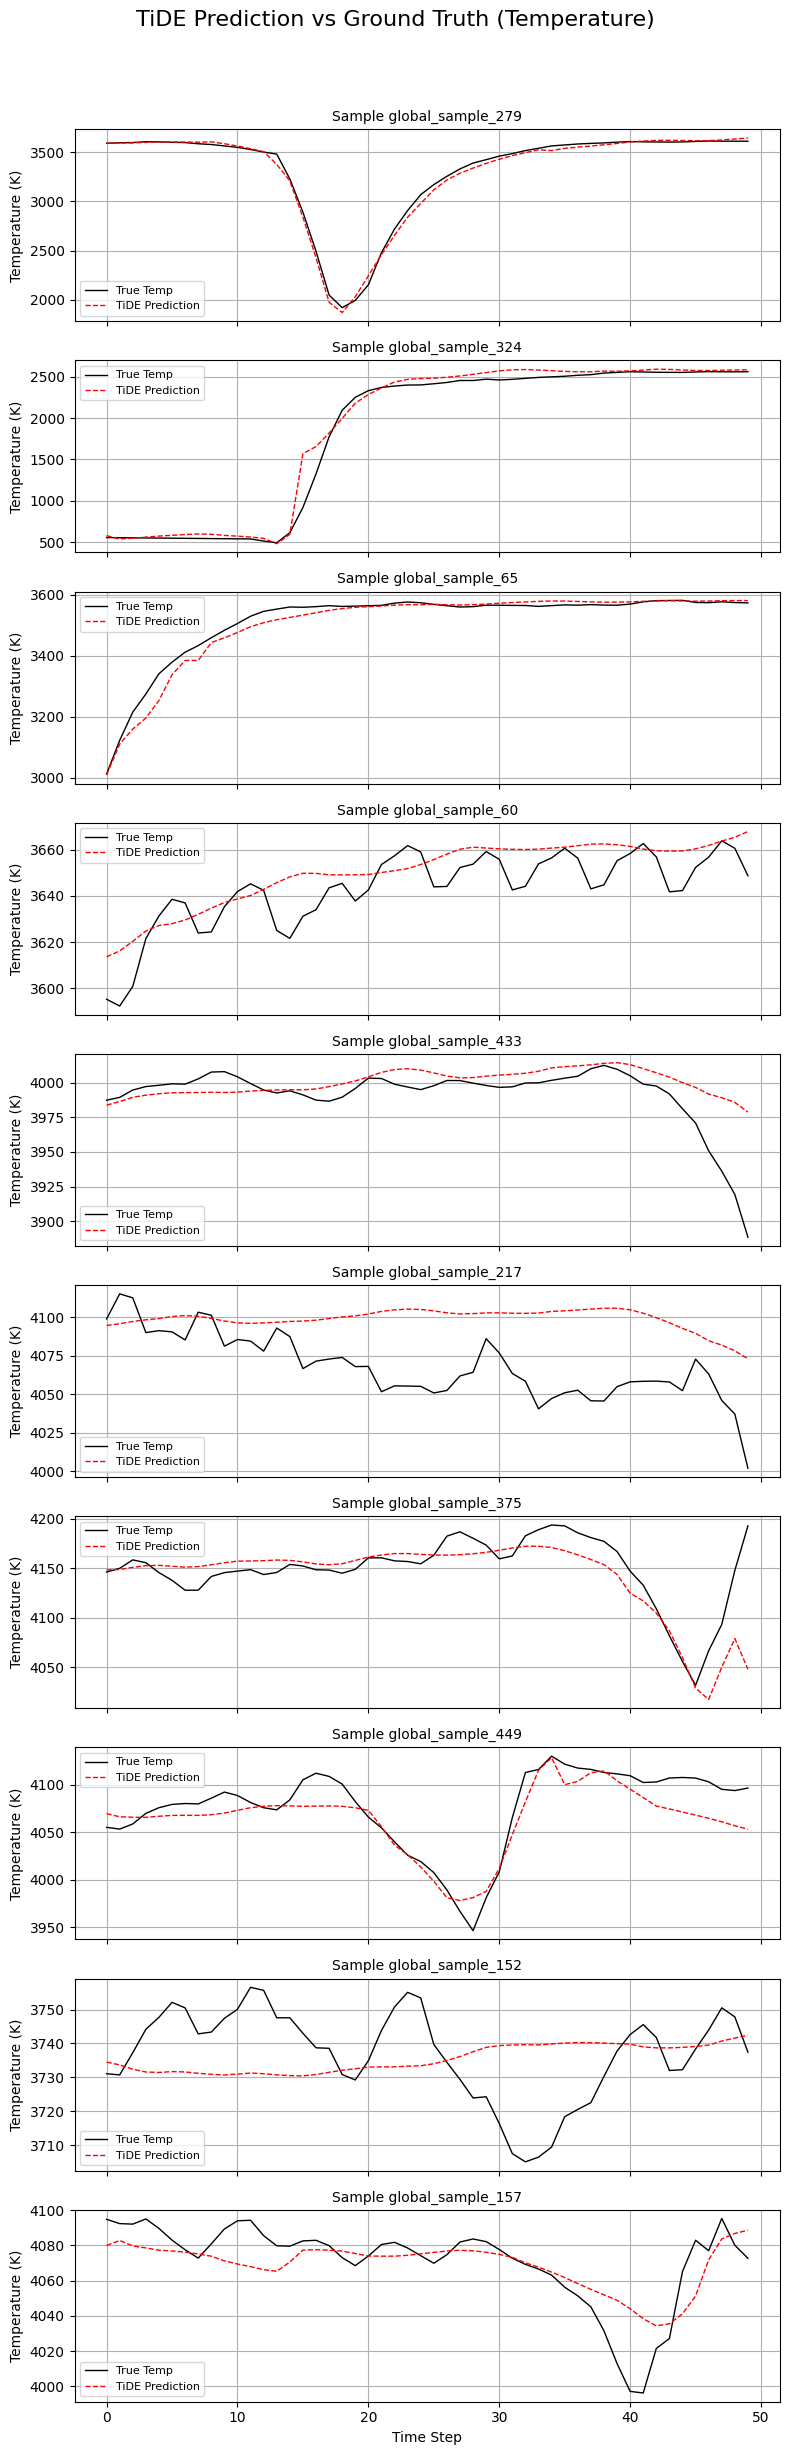

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# ── 설정 ────────────────────────────────
save_dir = "TiDE_eval_outputs_csv_global"
num_samples_to_plot = 10  # 시각화할 샘플 개수
csv_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".csv")])

# 선택된 샘플 무작위로 추출
selected_files = random.sample(csv_files, min(len(csv_files), num_samples_to_plot))

# ── 시각화 ───────────────────────────────
fig, axs = plt.subplots(len(selected_files), 1, figsize=(8, 2.5 * len(selected_files)), sharex=True)

if len(selected_files) == 1:
    axs = [axs]  # 1개면 list로 변환

fig.suptitle("TiDE Prediction vs Ground Truth (Temperature)", fontsize=16)

for i, filename in enumerate(selected_files):
    df = pd.read_csv(os.path.join(save_dir, filename))
    y_true = df["y_true_temp"].values
    y_pred = df["y_pred_temp"].values

    ax = axs[i]
    ax.plot(y_true, label="True Temp", color="black", linewidth=1)
    ax.plot(y_pred, label="TiDE Prediction", color="red", linestyle="--", linewidth=1)
    ax.set_ylabel("Temperature (K)")
    ax.set_title(f"Sample {filename.replace('.csv','')}", fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8)

axs[-1].set_xlabel("Time Step")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
